<a href="https://colab.research.google.com/github/MordecaiAbergel/22961-DeepLearning-mmns/blob/main/MAmmn12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***אני משתמשת בימים 1-7 ומגישה באיחור של 7 ימים***

# Mamamn 14

Asya Olshansky
Videos in Youtube:
1. Question 1: https://youtu.be/UD25yCfrBoI
2. Question 2: https://www.youtube.com/watch?v=CyHPlt5vIVk


# Question 1

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
!pip install torchviz
!pip install torchview
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=dfc5a430c585535475a4cca9213e52aed63cb33b0f03ec0b4b5e1b5154a3d5d1
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1  א 
# Implementation with inheritance from nn.Module with weights and biases explicitly set:

In [2]:
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
import torch.nn.functional as F
import torch.nn.init as init  #import init
import math

class SplitLinear(nn.Module):
    def __init__(self, in_features, out_features, num_groups=2, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()

        # Create a linear layer with half features in, and half features out.
        assert in_features % num_groups == 0, f"should be divided w/o remainder"
        assert out_features % num_groups == 0, f"should be divided w/o remainder"  
        
        self.in_features = int(in_features // num_groups) 
        self.out_features = int(out_features // num_groups) 

        print('number input / output featuers', self.in_features, self.out_features)
        # Initialize parameters:
        self.weight = Parameter(torch.empty((self.out_features, self.in_features), **factory_kwargs))
        self.bias = Parameter(torch.empty(self.out_features, **factory_kwargs))
        self.init_wei_bias()

        self.relu = nn.ReLU()

    def init_wei_bias(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        init.uniform_(self.bias, -bound, bound)

    def show_params(self, draw_hist=False):
      print('--- SplitLayer weight parameters: ')
      print('weigths shape: {} vals {}'.format(self.weight.shape, self.weight))
      print('bias shape: {} vals {}'.format(self.bias.shape, self.bias))
      
      if draw_hist:
        w_counts, w_bins = np.histogram(self.weight.detach().numpy().flatten(),density=False)
        b_counts, b_bins = np.histogram(self.bias.detach().numpy().flatten(),density=False)
        fig, axs = plt.subplots(1, 2)
        axs[0].stairs(w_counts, w_bins)#, fill=True)
        axs[0].set_title("Weight Histogram")
        axs[1].stairs(b_counts, b_bins)#, fill=True)
        axs[1].set_title("Bias Histogram")
      
    def print_layers(self, ):

        print('--- SplitLayer layer values: ')
  
        layers = ['x', 'z', 'y']

        for layer_name in layers:
          out_tensor_list = getattr(self, layer_name)
          for (k, out_tensor) in enumerate(out_tensor_list):
            print('{}[{}]'.format(layer_name,k), out_tensor.shape, out_tensor)
        
        print('y_final', self.y_final)

    def forward(self,X):
        # Split the data (X) into two halves, in the features dimension.
        #self.x1, self.x2 = torch.split(X, self.in_features, dim=1)
        self.x = torch.split(X, self.in_features, dim=1) # tuple (x1,x2,...,x_ng)
        # Layer output for both inputs.
        #self.z1, self.z2 = F.linear(self.x1, self.weight, self.bias), F.linear(self.x2, self.weight, self.bias)
        self.z = [F.linear(x, self.weight, self.bias) for x in self.x]
        #self.y1, self.y2 = self.relu(self.z1), self.relu(self.z2)
        self.y = [self.relu(z) for z in self.z]
        self.y_final = torch.cat(self.y, axis=1)
        # Link the halves and return them.
        return self.y_final

## 1 ב


## Explicit weight initialization:
Appropriate weight initialization is an important factor impacting the convergence and performance of a network. Weights that are initialized to the same value can cause the model to converge to the same suboptimal solution, regardless of the optimization algorithm being used.

Weights that are initialized to large values can lead to vanishing or exploding gradients, depending on the activation function being used. This can cause the model to converge slowly or not at all. Weights that are initialized to small random values can lead to more efficient training, as the optimization algorithm is able to make larger updates to the weights at the beginning of training. Different initialization methods can be more suitable for different types of problems and model architectures.


We borrow the elements of nn.Linear implementation and follow the suggestion of paper: https://paperswithcode.com/method/he-initialization
that sets weights in a smart way when Relu() is used in the net.



##1 ג 
# Print intermediate layer values


number input / output featuers 6 6
num_batches=2, num_features=12, num_groups=2
Input x:  tensor([[ 0.6098,  0.2435, -0.7296, -0.4806,  0.3412,  0.6770,  0.5534,  0.3002,
          0.2834, -1.8533,  0.5751, -0.4696],
        [ 0.2156, -0.6773, -0.4511,  0.2761,  0.5675,  2.0610, -2.0415, -1.1945,
          0.0423, -0.7729,  1.2738, -0.4213]])
--- SplitLayer weight parameters: 
weigths shape: torch.Size([6, 6]) vals Parameter containing:
tensor([[-0.1030,  0.3723, -0.1530, -0.2807, -0.3932, -0.3870],
        [ 0.3535, -0.2210, -0.3761,  0.2019,  0.1081,  0.0895],
        [ 0.2888,  0.2833, -0.4076, -0.0256,  0.2577,  0.2996],
        [-0.4059,  0.0655, -0.2261,  0.0242,  0.0843, -0.2085],
        [ 0.2756, -0.1691,  0.0843,  0.1511, -0.4043,  0.1893],
        [-0.3372,  0.0116, -0.0281, -0.2492, -0.1963, -0.1156]],
       requires_grad=True)
bias shape: torch.Size([6]) vals Parameter containing:
tensor([ 0.0988, -0.2813, -0.2958, -0.0785,  0.0257, -0.1402],
       requires_grad=True)
--

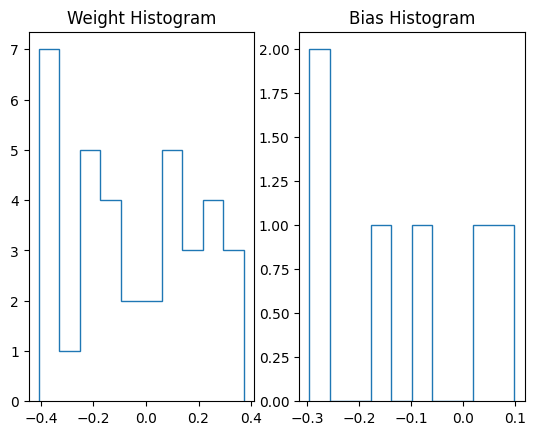

In [3]:
batch_size = 2
num_features = 12
num_groups = 2
model = SplitLinear(num_features, num_features, num_groups)

print('num_batches={}, num_features={}, num_groups={}'.format(batch_size, num_features, num_groups))

# View operations and parameters:
x = torch.randn(batch_size, num_features)
print('Input x: ', x)

#print('Model: ', model)
y=model(x)

# Print model paramers:
model.show_params(draw_hist=True)

# Print each layer results:
model.print_layers()


## 1 ד  
# Draw model layers and parameters
I found libraries that draw parameters and layers automatically. 

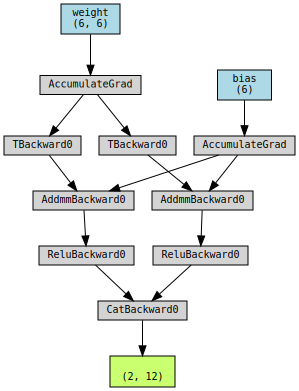

In [4]:
# View operations and parameters:
from torchviz import make_dot
make_dot(y, params=dict(model.named_parameters()))



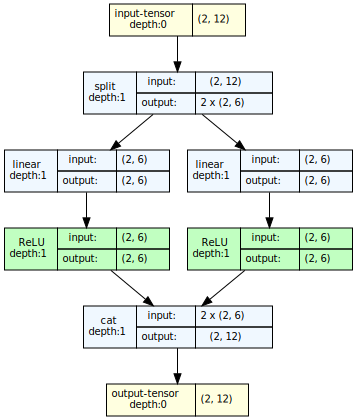

In [5]:
# View layers of the graph:

from torchview import draw_graph
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(batch_size, num_features), device='meta')
model_graph.visual_graph

## 1 ה

<u>**Theory**</u>  
The only parametreized layer is linear; the number of parameters for the linear layer is given by (for W matrix $N_{in} \times N_{out} $ and bias $N_{out}$):
$N_{in} N_{out} + N_{out}= (N_{in}+1) N_{out}$, where $N_{in}$ and $N_{out}$ are the number of
input/output neurons in the linear layer.

Given that the number of input and output features is $M$ and $P$, respectively and the number of groups is $N_g$.  

The number of parameters for split layer will be:
$NP_S = (M/N_g+1)P/N_g$ and without grouping the entire number of parameters
is $NP_L=(M+1)P$. 

The rate in the number of parameters: $\frac{NP_S}{NP_L} = \frac{(M/N_g+1)P/N_g}{(M+1)P} = \frac{M/N_g+1}{N_g(M+1)}$. The rate is independent of the number of output features and 
$\lim\limits_{M \to \infty}  \frac{M/N_g+1}{N_g(M+1)} =  \lim\limits_{M \to \infty} \frac{1/N_g+1/M}{N_g(1+1/M)} = \frac{1/N_g}{N_g} = \frac{1}{N_g^2}$.



In [6]:
# Get the number of parameters in layer.
def get_number_params(params):
    sum = 0
    for x in params:
        sum += x.numel()
    return sum

# Compare the number of parameters between the two layers.
def params_rate(lin_split, lin):
    np_lin_split = get_number_params(lin_split.parameters()) 
    np_lin = get_number_params(lin.parameters()) 
    rate = np_lin_split/np_lin
    print('CODE: split_lin_par={}, lin_par={}, rate={}'.format(np_lin_split, np_lin, rate))

def analytic_params_rate(M, P, ng=2):
    np_lin_split = (M//ng + 1)*(P//ng)
    np_lin = (M+1)*P
    rate = np_lin_split/np_lin
    print('Analytic: split_lin_par={}, lin_par={}, rate={}'.format(np_lin_split, np_lin, rate))

M = 6
P = 4 
lin_split = SplitLinear(M, P)
lin = nn.Linear(M, P)
params_rate(lin_split, lin)
analytic_params_rate(M, P)


number input / output featuers 3 2
CODE: split_lin_par=8, lin_par=28, rate=0.2857142857142857
Analytic: split_lin_par=8, lin_par=28, rate=0.2857142857142857


## 1 ו + ז
The document is a pdf so it is in the zip file, couldn't find away to attatch it into collab

# Question 2

In [7]:
''' Libraries required '''
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from tqdm import tqdm
from torch import nn

''' Debug when errors occur '''
from pdb import set_trace as pst
from pdb import pm

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 2Alef, 2Bet, 2Gimel

In [9]:
a = torch.rand(3,4,5)
a_f = a.flatten(start_dim=1)
print(a_f.shape, a_f)
x=a_f.sum(dim=1, keepdim=True)
list(range(10))

torch.Size([3, 20]) tensor([[0.2006, 0.0566, 0.9538, 0.5647, 0.4083, 0.2638, 0.2697, 0.3357, 0.9776,
         0.3421, 0.2908, 0.8487, 0.3360, 0.8867, 0.8778, 0.5381, 0.2811, 0.3358,
         0.1496, 0.4229],
        [0.8716, 0.8071, 0.7712, 0.6959, 0.6244, 0.0454, 0.3869, 0.9996, 0.7794,
         0.2978, 0.7017, 0.5599, 0.9772, 0.2968, 0.4283, 0.3405, 0.7404, 0.1917,
         0.4003, 0.6201],
        [0.8911, 0.8328, 0.9518, 0.8828, 0.6415, 0.2775, 0.9555, 0.5873, 0.0641,
         0.8482, 0.3179, 0.5888, 0.0232, 0.7362, 0.6408, 0.3138, 0.4101, 0.8827,
         0.2612, 0.1450]])


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [10]:
class DropNorm(nn.Module):

    def __init__(self, in_features, drop_rate=0.5):
        "in_features - input tensor shape as a list or a number, e.g. [2,5], 4"
        
        super().__init__()
        assert(0 < drop_rate < 1)

        self.drop_rate = drop_rate
        
        # flattened tensor - dimensionality
        if isinstance(in_features, int):
            self.num_in_features = in_features
        else:
            self.num_in_features = np.prod(in_features)
        
        self.num_drop_features = int(self.num_in_features*drop_rate)
        self.num_nozero_features = self.num_in_features - self.num_drop_features
     

        #just values to be calculated per batch:
        #self.mu_avg = torch.tensor([0]).to(device)
        #self.sigma2_avg = torch.tensor([1]).to(device)
        
        # trained params: 
        self.gamma = nn.Parameter(torch.ones(self.num_in_features)).to(device)
        self.beta = nn.Parameter(torch.zeros(self.num_in_features)).to(device)

    def dropout(self, X):
        X = X.flatten(start_dim=1) # flatten: n_batch x n_in_features
 
        # indices of features to drop
        indices = np.random.choice(range(self.num_in_features), 
                                   size=self.num_drop_features,
                                   replace=False
                                   )
        # create dropout mask, the same features for all samples in batch
        mask = torch.ones((1, self.num_in_features), device=device)
        mask[:, indices] = 0
        
        # To solve the problem of different signal strength during 
        # training/test, divide by (1−drop_rate), as PyTorch does.
        
        return X*mask, mask
        
    def normalization_train(self, X_drop, mask, eps=1e-5):
        """ 
          X is flattended num_batches x num_features 
        """
        
        # sum of all no-zero features in the batch per sample, divided by non-zero - elements
        # mu, sigma2 - [n_batch, 1]
        mu = torch.sum(X_drop, dim=1, keepdim=True)/self.num_nozero_features
        
        # m2 = E[x^2], sigma2 = E(x-mu)^2 = E(x^2) - mu^2 
        m2 = torch.sum(torch.square(X_drop), dim=1, keepdim=True)/self.num_nozero_features
        sigma2 = m2 - mu*mu
        # sigma2 = torch.where(sigma2 > 0, sigma2, 0) # instability (1) resolved by (2) as well     

        X_hat = (X_drop - mu)/torch.sqrt(sigma2 + eps) # instability (2)
        
        # Output:
        y = self.gamma*X_hat + self.beta

        # set modified zero elements -> back to zero now
        # dropped -> zero 
        return y*mask
    

    def normalization_eval(self, X, eps=1e-5):
        """
          X - is flattened: [n_batch x n_features] 
        """
        X = X.flatten(start_dim=1)
        mu = torch.mean(X, dim=1, keepdim=True) # n_batch x 1
        sigma2 = torch.var(X, dim=1, keepdim=True) # n_batch x 1
        X_hat = (X - mu)/torch.sqrt(sigma2 + eps) # instability (2)

        with torch.no_grad():
          y = self.gamma*X_hat + self.beta

        return y

    def forward(self, X):
        # go through dropout only when training
        X_shape = X.shape # original X shape
        
        
        if self.training:
            X_drop, mask  = self.dropout(X)
            Y = self.normalization_train(X_drop, mask)
        else:
            Y = self.normalization_eval(X)
            Y = Y*(1 - self.drop_rate)

        return Y.reshape(X_shape)

In [11]:
''' simple test for dropout '''
size = (2,4,4)
X = torch.rand(size, device=device)
print(X)


in_features = list(size[1:])
print('input_features ', in_features)

DN_model = DropNorm(in_features)
print(DN_model)



X_f = X.flatten(start_dim=1)
print("Original flattened tensor:\n",X_f,'\n',sep='')

X_drop, mask = DN_model.dropout(X)
print("Dropout mask:\n", mask, sep='')
print("After dropout X_drop:\n", X_drop, sep='')


Y = DN_model.normalization_train(X_drop=X_drop, mask=mask)
print('Output Y:',Y)

tensor([[[0.7460, 0.3213, 0.5103, 0.0854],
         [0.7727, 0.1786, 0.9217, 0.6139],
         [0.1271, 0.8252, 0.8105, 0.2935],
         [0.9416, 0.9487, 0.7390, 0.4970]],

        [[0.1418, 0.6683, 0.4930, 0.4017],
         [0.8568, 0.8079, 0.2829, 0.1470],
         [0.5544, 0.2095, 0.2582, 0.5418],
         [0.6275, 0.6621, 0.1653, 0.3036]]], device='cuda:0')
input_features  [4, 4]
DropNorm()
Original flattened tensor:
tensor([[0.7460, 0.3213, 0.5103, 0.0854, 0.7727, 0.1786, 0.9217, 0.6139, 0.1271,
         0.8252, 0.8105, 0.2935, 0.9416, 0.9487, 0.7390, 0.4970],
        [0.1418, 0.6683, 0.4930, 0.4017, 0.8568, 0.8079, 0.2829, 0.1470, 0.5544,
         0.2095, 0.2582, 0.5418, 0.6275, 0.6621, 0.1653, 0.3036]],
       device='cuda:0')

Dropout mask:
tensor([[0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.]],
       device='cuda:0')
After dropout X_drop:
tensor([[0.0000, 0.3213, 0.0000, 0.0000, 0.7727, 0.0000, 0.0000, 0.0000, 0.0000,
         0.8252, 0.8105, 0.2935, 0.941

## Dropout implementation 
During evaluation all features will be used, while during training only their part $1-p$, where $p$ - is the dropout probability.  
Lets assume that $X \in R^N$ is output and all its features are distributed the same as some random variable $F$. Lets assume that mean of absolute of $F$ is  $\mu_f= E{|F|}$, then average of norm of $X$ without dropout: 
$E [|X|_{L_1} ] = E[ \sum_{k=1}^{N}  |X_k|] = \sum_{k=1}^{N} E|X_k| =N\mu_f$. For droppped out vector, only is $(1-p)N$ components are non zero and thus $E [|X_{drop}|_{L_1}] = N(1-p) \mu_f$. I.e. norm of dropped vector is $1-p$ times smaller than norm of untouched $X$. The idea is to decrease the norm of the output vector in the evaluation step by multiplying it by $1-p$ to match to norm of $X_{drop}$ used during training.  

## Parameters initialization
$\gamma=1$ and $\beta=0$ - correspond to not correcting mean and variance of the $\hat{x}$-normalized vector;  and thus are reasonable initialization parameters.


## 2D

In [12]:
'''  Load the Fashion-MNIST dataset '''
trans=torchvision.transforms.Compose(
    [torchvision.transforms.PILToTensor(),
     torchvision.transforms.ConvertImageDtype(torch.float)])

train_data = torchvision.datasets.FashionMNIST(
    root="/22961", train=True, download=True,
    transform=trans)

test_data = torchvision.datasets.FashionMNIST(
    root="/22961", train=False, download=True,
    transform=trans)

''' Data loader for training and test sets '''
# test_batch adjusts itself to train_batch so the model will run
# the same order of batches on they both.
train_minibatch = 256
test_minibatch = train_minibatch // (len(train_data)//len(test_data))

train_dataloader = DataLoader(train_data, batch_size=train_minibatch,
                              num_workers=1,shuffle=True,pin_memory=True)
train_batches=len(train_dataloader)

test_dataloader = DataLoader(test_data, batch_size=test_minibatch,
                              num_workers=1,shuffle=True,pin_memory=True)
test_batches=len(test_dataloader)

100%|██████████| 26421880/26421880 [00:01<00:00, 17797113.37it/s]


Extracting /22961/FashionMNIST/raw/train-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300319.94it/s]


Extracting /22961/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5561584.65it/s]


Extracting /22961/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19007286.08it/s]

Extracting /22961/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw



In [13]:
''' Define model 1: dropout followed by batch-normalization, normalization over samples in mini-batch '''
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(784,64),nn.ReLU(),
                      nn.Dropout(), nn.BatchNorm1d(num_features=64),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim=1)).to(device)

CE_loss=nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
''' iterate batch on train/test mode '''
def iterate_batch(model,optimizer,imgs,labels,train=True):
    imgs = imgs.to(device)
    labels=labels.to(device)

    if train:
        model.train()
        optimizer.zero_grad()
        y_model=model(imgs)
        loss=CE_loss(y_model,labels)
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            y_model = model(imgs)
            loss = CE_loss(y_model,labels)
    
    predicted_labels = y_model.argmax(dim=1)
    acc = (predicted_labels == labels).sum()/len(labels)
    
    return loss, acc

In [15]:
''' train model 1: '''
train_loss=torch.empty(train_batches,device=device)
train_acc=torch.empty(train_batches,device=device)
for idx, (imgs, labels) in tqdm(enumerate(train_dataloader)):
    train_loss[idx], train_acc[idx] = iterate_batch(model, optimizer, imgs, labels)

235it [00:20, 11.68it/s]


In [16]:
''' test model 1 '''
test_loss=torch.empty(test_batches,device=device)
test_acc=torch.empty(test_batches,device=device)
for idx, (imgs, labels) in tqdm(enumerate(test_dataloader)):
    test_loss[idx], test_acc[idx] = iterate_batch(model, optimizer, imgs, labels,train=False)

239it [00:02, 95.14it/s]


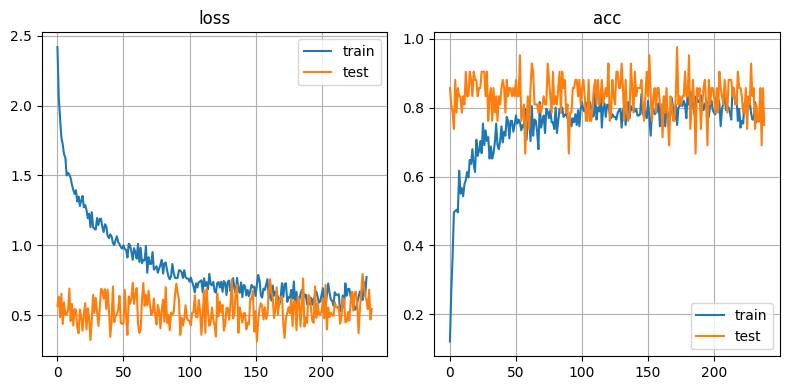

In [17]:
''' plot loss and accuracy graphs '''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

ax1.plot(train_loss.cpu().detach())
ax1.plot(test_loss.cpu().detach())
ax1.grid()
ax1.set_title('loss')
ax1.legend(['train','test'])

ax2.plot(train_acc.cpu().detach())
ax2.plot(test_acc.cpu().detach())
ax2.grid()
ax2.set_title('acc')
_ =ax2.legend(['train','test'])

## 2E

In [18]:
''' Define model 2 '''
model2 = nn.Sequential(nn.Flatten(),
                      nn.Linear(784,64),nn.ReLU(),
                      DropNorm(64, drop_rate=0.5),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim=1)).to(device)

CE_loss=nn.NLLLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [19]:
''' train model 2 '''
train_loss2=torch.empty(train_batches,device=device)
train_acc2=torch.empty(train_batches,device=device)
for idx, (imgs, labels) in tqdm(enumerate(train_dataloader)):
    train_loss2[idx], train_acc2[idx] = iterate_batch(model2, optimizer2, imgs, labels)

235it [00:11, 20.83it/s]


In [20]:
''' test model 2 '''
test_loss2=torch.empty(test_batches,device=device)
test_acc2=torch.empty(test_batches,device=device)
for idx, (imgs, labels) in tqdm(enumerate(test_dataloader)):
    test_loss2[idx], test_acc2[idx] = iterate_batch(model2, optimizer2, imgs, labels,train=False)

239it [00:02, 93.42it/s]


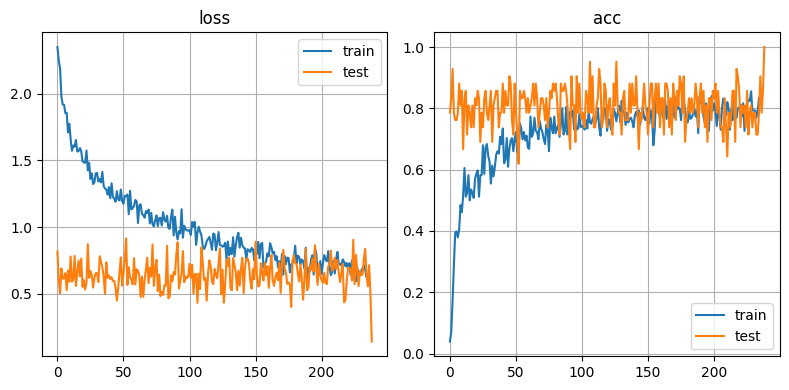

In [21]:
''' plot loss and accuracy graphs '''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

ax1.plot(train_loss2.cpu().detach())
ax1.plot(test_loss2.cpu().detach())
ax1.grid()
ax1.set_title('loss')
ax1.legend(['train','test'])

ax2.plot(train_acc2.cpu().detach())
ax2.plot(test_acc2.cpu().detach())
ax2.grid()
ax2.set_title('acc')
_ =ax2.legend(['train','test'])

## 2F

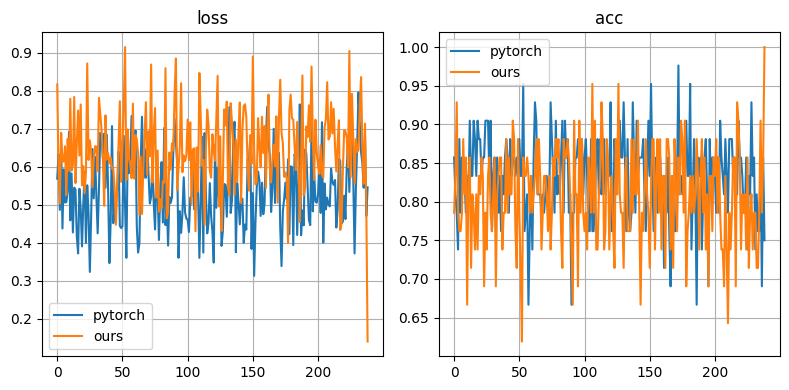

In [22]:
''' Compare the two models. '''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

ax1.plot(test_loss.cpu().detach())
ax1.plot(test_loss2.cpu().detach())
ax1.grid()
ax1.set_title('loss')
ax1.legend(['pytorch','ours'])

ax2.plot(test_acc.cpu().detach())
ax2.plot(test_acc2.cpu().detach())
ax2.grid()
ax2.set_title('acc')
_ =ax2.legend(['pytorch','ours'])

Performance results of Pytorch implementation are better: accuracy slightly higher for pytorch and loss is worse for our model (larger for our model). Pytorch implements  dropout and normalization sequentially, that gives more flexibility and control in the usage; as well as the features are normalized using $\mu, \sigma$ calculated over batch samples; while in our implementation over features per sample. 